# Bert2Bert finetuning

In this notebook, we show the training procedure we developed for our task. The task was to take two encoder BERT-like models trained by Allegro Research called HerBERT, stack them in order to make an encoder-decoder model, and train it to generate summeries based on supplied longer text.

## Installs and imports

### Important libraries not preinstalled

We havily rely on the high-level transformers library and its datsets wrapper.

In [ ]:
!pip install transformers datasets rouge_score
!pip install wandb -qqq

### Imports

In [ ]:
from collections import OrderedDict
import subprocess
import time
import xml.etree.ElementTree
import torch
import transformers
import datasets
from dataclasses import dataclass, field
from typing import Optional
import wandb
import os
import shutil
import json
from datetime import datetime

### Some utility methods

Below, you can find three utility methods:
1. check_gpu_usage - GPU state checker showing its utilization and total memory - usefull for choosing the batch size,
2. get_last_checkpoint - method finding the last checkpoint directory saved during the training in order to upload it to wandb.ai,
3. move_with_overwrite - used for saving a checkpoint as an wandb.ai artifact.

In [ ]:
def check_gpu_usage():
    def extract(elem, tag, drop_s):
        text = elem.find(tag).text
        if drop_s not in text: raise Exception(text)
        text = text.replace(drop_s, "")
        try:
            return int(text)
        except ValueError:
            return float(text)

    i = 0

    d = OrderedDict()
    d["time"] = time.time()

    cmd = ['nvidia-smi', '-q', '-x']
    cmd_out = subprocess.check_output(cmd)
    gpu = xml.etree.ElementTree.fromstring(cmd_out).find("gpu")

    total_memory = torch.cuda.get_device_properties(device='cuda').total_memory/(2**20)
    util = gpu.find("utilization")
    d["gpu_util"] = extract(util, "gpu_util", "%")

    d["mem_used"] = extract(gpu.find("fb_memory_usage"), "used", "MiB")
    d["mem_used_per"] = d["mem_used"] * 100 / total_memory #11171

    if d["gpu_util"] < 15 and d["mem_used"] < 2816:
        msg = 'GPU status: Idle \n'
    else:
        msg = 'GPU status: Busy \n'

    now = time.strftime("%c")
    print('\n\nUpdated at %s\n\nGPU utilization: %s %%\nVRAM used: %s %%\n\n%s\n\n' % (
        now, d["gpu_util"], d["mem_used_per"], msg))
    print(f'Total ram available: {total_memory} MBs')


check_gpu_usage()



Updated at Mon Sep 13 22:05:38 2021

GPU utilization: 0 %
VRAM used: 0.026221054414150628 %

GPU status: Idle 



Total ram available: 11441.1875 MBs


In [ ]:
def get_last_checkpoint():
    checkpoint_list = [item for item in os.listdir(path='./checkpoints') if 'checkpoint' in item]
    max = 1 
    for checkpoint in checkpoint_list:
        checkpoint_id = int(checkpoint.split('-')[-1])
        if max < checkpoint_id:
            max = checkpoint_id
    return 'checkpoint-'+str(max)

In [ ]:
def move_with_overwrite(src, dst):
    root_src_dir = src
    root_dst_dir = dst

    for src_dir, dirs, files in os.walk(root_src_dir):
        dst_dir = src_dir.replace(root_src_dir, root_dst_dir, 1)
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        for file_ in files:
            src_file = os.path.join(src_dir, file_)
            dst_file = os.path.join(dst_dir, file_)
            if os.path.exists(dst_file):
                # in case of the src and dst are the same file
                if os.path.samefile(src_file, dst_file):
                    continue
                os.remove(dst_file)
            shutil.move(src_file, dst_dir)

## Weights and biases login

[Weights and biases](https://wandb.ai) is a library for versioning models&datasets and for monitoring the training proces of machine learning models. It allows to collect data from system, metrics and weights.
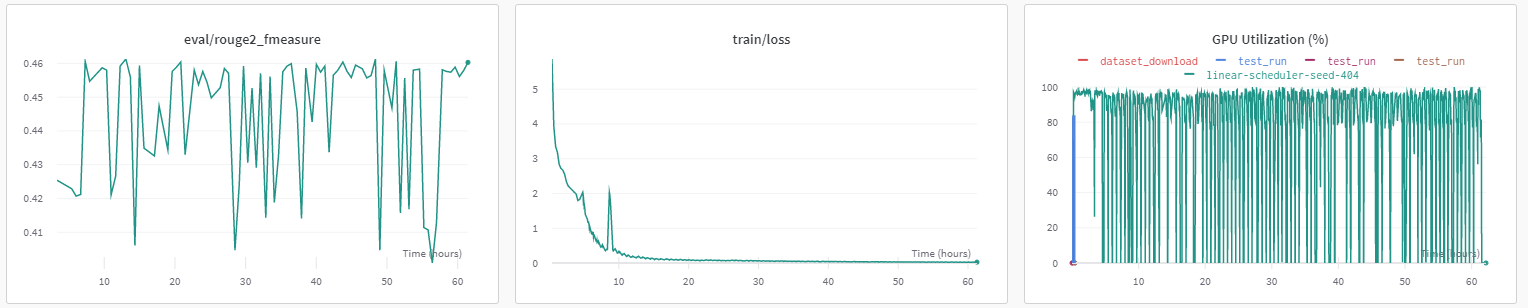 

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Dataset download

Here, we have our dataset stored as an artifact on wandb.ai server in several versions.

In [ ]:
with wandb.init(project='psc', entity='pns', name='dataset_download') as run:
  artifact = run.use_artifact('pns/psc/tvn_psc:v6', type='dataset')
  artifact_dir = artifact.download()
train_data = datasets.load_dataset('csv', data_files={'train': artifact_dir+'/tvn_train.csv'}, split='train')
val_data = datasets.load_dataset('csv', data_files={'validation': artifact_dir+'/tvn_validation.csv'}, split='validation')
test_data = datasets.load_dataset('csv',data_files={'test': artifact_dir+'/tvn_test.csv'}, split='test')

wandb: Currently logged in as: pgrabinski (use `wandb login --relogin` to force relogin)


wandb: Downloading large artifact tvn_psc:v6, 360.49MB. 3 files... Done. 0:0:0


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-2930b92d10b38df2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-2930b92d10b38df2/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-b0ff2c4242176274


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b0ff2c4242176274/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration default-4aaaf05603461fe9


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4aaaf05603461fe9/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff. Subsequent calls will reuse this data.


### Run definition

Below, we decide either to start a new run or resume it from a saved checkpoint.

In [ ]:
transformers.set_seed(404)
entity = 'tvn_only'
project = 'tvn_psc_v6'
# True for new model, False for further training.
new_model = False
run_name = None #'linear-scheduler-seed-404'
run_id = '26xpkaeg'
# REMEMBER TO PICK CORRECT VERSIONS OF THE CHECKPOINT AND TRAINING ARGS!
training_checkpoint_version = 'tvn_only/tvn_psc_v6/training_checkpoint:v6'
training_args_version = 'tvn_only/tvn_psc_v6/training_args:v2'
if new_model:
    if run_name is None:
        raise Exception('No run_name provided!')
    if run_id is not None:
        raise Exception('run_id is not necessary for a new run.')
else:
    if run_name is not None:
        raise Exception('run_name is not necessary for a new run.')
    if run_id is None:
        raise Exception('No run_id provided!')

In [ ]:
# transformers.set_seed(404)
# entity = 'tvn_only'
# project = 'tvn_psc_v6'
# # True for new model, False for further training.
# new_model = True
# run_name = 'linear-scheduler-seed-404'
# run_id = None #'1qzp1s5q'
# # REMEMBER TO PICK CORRECT VERSIONS OF THE CHECKPOINT AND TRAINING ARGS!
# training_checkpoint_version = None#'tvn_mod/tvn_psc/training_checkpoint:v9'
# training_args_version = None #'tvn_mod/tvn_psc/training_args:v2'
# if new_model:
#     if run_name is None:
#         raise Exception('No run_name provided!')
#     if run_id is not None:
#         raise Exception('run_id is not necessary for a new run.')
# else:
#     if run_name is not None:
#         raise Exception('run_name is not necessary for a new run.')
#     if run_id is None:
#         raise Exception('No run_id provided!')

## Prepare tokenizer, model, and dataset

We are using the tokenizer from the original HerBERT model that we used for our encoder-decoder model.

In [ ]:
# Tokenizer setup
tokenizer_name = 'allegro/herbert-klej-cased-tokenizer-v1'
tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_name)
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/591k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/300 [00:00<?, ?B/s]

### Model definition or reload

If we start a new run, we instatiate the encoder-decoder model from two HerBERTs.

And if we resume a run, we reload the model from a saved checkpoint.

In [ ]:
if new_model:
    model_name = 'allegro/herbert-klej-cased-v1'

    # Model setup
    bert2bert = transformers.EncoderDecoderModel.from_encoder_decoder_pretrained(model_name, model_name)

    bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
    bert2bert.config.eos_token_id = tokenizer.eos_token_id
    bert2bert.config.pad_token_id = tokenizer.pad_token_id

    bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size
    bert2bert.config.max_length = 142
    bert2bert.config.min_length = 56
    bert2bert.config.no_repeat_ngram_size = 3
    bert2bert.config.early_stopping = True
    bert2bert.config.length_penalty = 2.0
    bert2bert.config.num_beams = 4

    wandb_run = wandb.init(job_type="model-training", project=project,    
                name=run_name, entity=entity)
    last_checkpoint_path = './last_checkpoint'
    batch_size = 2

else:
    wandb_run = wandb.init(project=project, id=run_id,
                           entity=entity, resume='allow')
    checkpoint_artifact = wandb_run.use_artifact(training_checkpoint_version, type='checkpoint') 
    last_checkpoint_path = checkpoint_artifact.download()
    training_args_artifact = wandb_run.use_artifact(training_args_version, type='training_args')
    training_args_dir = training_args_artifact.download()
    with open(os.path.join(training_args_dir, 'training_args.json'), 'r') as file:
        training_args_dict = json.load(file)
    batch_size = training_args_dict['per_device_train_batch_size']
    bert2bert = transformers.AutoModelForSeq2SeqLM.from_pretrained(last_checkpoint_path)

encoder_max_length = 512
decoder_max_length = 128

wandb: Downloading large artifact training_checkpoint:v6, 3180.99MB. 12 files... Done. 0:0:0


Our data consists of Polish Summaries Corpus and TVN24 news articles and their summaries. PSC consists of 569 articles where each of them is extractivly summarized at least three times on different word count percentages of the original text some also have abstractive summarizations.​ TVN24 news are scraped from TVN24 latest articles website. Let's look at the total size of our data.

In [ ]:
print(f'Length of the train set: {len(train_data)}')
print(f'Length of the validation set: {len(val_data)}')
print(f'Length of the test set: {len(test_data)}')

Length of the train set: 110289
Length of the validation set: 6127
Length of the test set: 6128


### Dataset tranformation

We tokenize the dataset and truncate and pad it to the fixed max_length.



In [ ]:
def process_data_to_model_inputs(batch):
    # tokenize the inputs and labels
    inputs = tokenizer(batch["body_text"], padding="max_length", truncation=True, max_length=encoder_max_length)
    outputs = tokenizer(batch["summary"], padding="max_length", truncation=True, max_length=decoder_max_length)

    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask
    batch["decoder_input_ids"] = outputs.input_ids
    batch["decoder_attention_mask"] = outputs.attention_mask
    batch["labels"] = outputs.input_ids.copy()

    # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`.
    # We have to make sure that the PAD token is ignored
    batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in
                       batch["labels"]]

    return batch

In [ ]:
train_data = train_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["body_text", "summary"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)


val_data = val_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["body_text", "summary"]
)

val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

  0%|          | 0/13787 [00:00<?, ?ba/s]

  0%|          | 0/766 [00:00<?, ?ba/s]

### Metric

We are using the ROUGE metric used for summarization task.

In [ ]:
rouge = datasets.load_metric("rouge")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

## Training

We measure everything in steps. Here, we define how often we log, evaluate, and save our model.

In [ ]:
steps_per_epoch = len(train_data)/batch_size
steps_per_epoch = int(steps_per_epoch) if int(steps_per_epoch)==steps_per_epoch else int(steps_per_epoch)+1
epochs_per_eval = 0.5
epochs_per_save = 1
epochs_per_log = 0.01
eval_steps = int(steps_per_epoch * epochs_per_eval) 
logging_steps = int(steps_per_epoch*epochs_per_log)
save_steps = int(steps_per_epoch * epochs_per_save)

### Model-saving callback

We use a callback that uploads the last checkpoint of our model as an artifact to wandb.ai after every save.

In [ ]:
class VersionModelCallback(transformers.TrainerCallback):  
    def on_save(self, args, state, control, **kwargs):
        # check last checkpoint
        last_checkpoint = get_last_checkpoint()
        checkpoints_path = './checkpoints'
        last_checkpoint_dir = os.path.join(checkpoints_path, last_checkpoint)

        # Upload new training
        state_artifact = wandb.Artifact('training_checkpoint', type='checkpoint')
        last_checkpoint_path = './last_checkpoint'
        if not os.path.isdir(last_checkpoint_path):
            os.mkdir(last_checkpoint_path)
        move_with_overwrite(src=last_checkpoint_dir, dst=last_checkpoint_path)
        state_artifact.add_dir(last_checkpoint_path)
        self.run.log_artifact(state_artifact)
        state_artifact.wait()

        print(f'{datetime.now().strftime("%d/%m/%Y %H:%M:%S")}: Uploaded {last_checkpoint}.')

    def add_artifacts(self,   run):
        self.run = run

model_callback = VersionModelCallback()
model_callback.add_artifacts(run=wandb_run)

### Training arguments

We either define them or reload from a previous run.

In [ ]:
if new_model:
    training_args = transformers.Seq2SeqTrainingArguments(
        output_dir="./checkpoints/",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        predict_with_generate=True,
        do_train=True,
        do_eval=True,
        save_steps=save_steps,
        logging_steps=logging_steps,
        eval_steps=eval_steps, 
        warmup_steps=0,
        evaluation_strategy='steps',
        logging_strategy='steps',
        save_strategy='steps',
        overwrite_output_dir=True,
        lr_scheduler_type='linear',
        save_total_limit=1,
        fp16=True,
        num_train_epochs=100,
        report_to="wandb",
        load_best_model_at_end=False
    )
else:
    training_args = transformers.Seq2SeqTrainingArguments(
        output_dir=training_args_dict['output_dir'],
        per_device_train_batch_size=training_args_dict['per_device_train_batch_size'],
        per_device_eval_batch_size=training_args_dict['per_device_eval_batch_size'],
        predict_with_generate=training_args_dict['predict_with_generate'],
        do_train=training_args_dict['do_train'],
        do_eval=training_args_dict['do_eval'],
        save_steps=training_args_dict['save_steps'],
        logging_steps=training_args_dict['logging_steps'],
        eval_steps=training_args_dict['eval_steps'], 
        warmup_steps=training_args_dict['warmup_steps'],
        evaluation_strategy=training_args_dict['evaluation_strategy'],
        logging_strategy=training_args_dict['logging_strategy'],
        save_strategy=training_args_dict['save_strategy'],
        overwrite_output_dir=training_args_dict['overwrite_output_dir'],
        lr_scheduler_type=training_args_dict['lr_scheduler_type'],
        save_total_limit=training_args_dict['save_total_limit'],
        fp16=training_args_dict['fp16'],
        num_train_epochs=training_args_dict['num_train_epochs'],
        report_to="wandb",
        load_best_model_at_end=training_args_dict['load_best_model_at_end']
    )


# instantiate trainer
trainer = transformers.Seq2SeqTrainer(
    model=bert2bert,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    callbacks=[model_callback]
)

Using amp fp16 backend


If the model is new, we save the training arguments to wandb.ai

In [ ]:
if new_model:
    training_args_dict = training_args.to_dict()
    with open('./training_args.json', 'w') as file:
        json.dump(training_args_dict, file)
    training_args_artifact = wandb.Artifact('training_args', type='training_args')
    training_args_artifact.add_file('./training_args.json')
    wandb_run.log_artifact(training_args_artifact)
    training_args_artifact.wait()

### Training loop

In [ ]:
if new_model:
    trainer.train()
else:
    trainer.train(resume_from_checkpoint=last_checkpoint_path)

In [ ]:
wandb.finish()

In [ ]:
check_gpu_usage()